In [1]:
%load_ext autoreload
%autoreload 2

In [692]:
%matplotlib inline

import sys
sys.path.append('../src/')

import glob
import warnings

import numpy as np
import pandas as pd
import xarray as xr

from scipy.optimize import curve_fit, minimize

# Plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from cmocean import cm
import hvplot.xarray

from sklearn.linear_model import LinearRegression

from epsilon_tools import *
from tools import str2date, avg_funs, integrate_columns, first_finite
from qc import qc_turbulence

import warnings
warnings.simplefilter("ignore",category=FutureWarning)
warnings.simplefilter("ignore",category=RuntimeWarning)

# set up figure params
sns.set(style='ticks', context='poster', palette='colorblind')
mpl.rc('figure', dpi=100, figsize=[12, 6])
mpl.rc('savefig', dpi=500, bbox='tight')
mpl.rc('legend', frameon=False)


sns.set(style="ticks", context="talk")
# plt.style.use("dark_background")

In [729]:
def qc_turbulence(data):
    '''
    clean chi and eps with RC's scripts
    '''
    # infile = 'data/xarray/xr_7784b.nc'
    # data = xr.open_dataset(str(infile))

    dtdzmin = 1.5e-3
    chimax = 5e-5
    kTmax = 1e-1
    zmin = 0 # disabled
    # for ratios
    lb = 0.5
    ub = 2

    floats = np.array([
        '7779a', '7781a', '7783a', '7786a', '7787a', '7788a',
        '7700b', '7701b','7780b', '7784b', '7785b', '7786b'
    ])
    fi = np.where(floats == data.floatid)[0][0]
    good_chi1, good_chi2 = np.load('../data/xarray/good_chi.npy')

#     # 1) thresholds for chi
#     data['dtdz1'] = np.sqrt(0.5 * data.chi1 / data.kT1)
#     data['dtdz2'] = np.sqrt(0.5 * data.chi2 / data.kT2)

#     bad = (data.dtdz1 <= dtdzmin) | (data.chi1 >= chimax) | (data.kT1 >= kTmax)
#     data['chi1'] = data['chi1'].where(~bad)
#     data['kT1'] = data['kT1'].where(~bad)
#     data['eps1'] = data['eps1'].where(~bad)

#     bad = (data.dtdz2 <= dtdzmin) | (data.chi2 >= chimax) | (data.kT2 >= kTmax)
#     data['chi2'] = data['chi2'].where(~bad)
#     data['kT2'] = data['kT2'].where(~bad)
#     data['eps2'] = data['eps2'].where(~bad)

#     # 2) periods of functioning chi sensor
#     tmin, tmax = str2date(good_chi1[fi, 0]), str2date(good_chi1[fi, 1])
#     bad = (data.time < tmin) | (data.time > tmax)
#     data['chi1'] = data['chi1'].where(~bad)
#     data['kT1'] = data['kT1'].where(~bad)
#     data['eps1'] = data['eps1'].where(~bad)

#     tmin, tmax = str2date(good_chi2[fi, 0]), str2date(good_chi2[fi, 1])
#     bad = (data.time < tmin) | (data.time > tmax)
#     data['chi2'] = data['chi2'].where(~bad)
#     data['kT2'] = data['kT2'].where(~bad)
#     data['eps2'] = data['eps2'].where(~bad)

    # 3) compare two sensors
    def combine_fun(array1, array2, lb=lb, ub=ub):
        ratio = array1 / array2
        bad = (ratio <= lb) | (ratio >= ub)

        chi1fin = np.isfinite(array1)
        chi2fin = np.isfinite(array2)

        a1 = np.minimum(array1.where(bad & chi1fin),
                        array2.where(bad & chi1fin))
        a2 = np.minimum(array1.where(bad & chi2fin),
                        array2.where(bad & chi2fin))
        a3 = avg_funs(array1.where(~bad), array2.where(~bad))

        concat = xr.concat([a1, a2, a3], dim='temp')
        return concat.mean(dim='temp')

    data['kT'] = combine_fun(data.kT1, data.kT2)
    data['chi'] = combine_fun(data.chi1, data.chi2)
    data['eps'] = combine_fun(data.eps1, data.eps2)

#     data = data.drop(
#         ['eps1', 'eps2', 'chi1', 'chi2', 'kT1', 'kT2', 'dtdz1', 'dtdz2'])
    return data

In [803]:
def qc_velocity(data):
    '''
    qc EM velocity measurements based on vertical movement and rotation rate of the float
    '''
    Wmin = 0.05
    RotPmax = 20
    verrmax = 0.1 # original 0.02

    # where cond:  what to keep!
    uv_mask = (np.abs(data.W) > Wmin) & (data.RotP < RotPmax)
    u1_mask = uv_mask & (data.verr1 < verrmax)
    u2_mask = uv_mask & (data.verr2 < verrmax)

    data['u1'] = data.u1.where(u1_mask)
    data['u2'] = data.u2.where(u2_mask)
    data['v1'] = data.u1.where(u1_mask)
    data['v2'] = data.v2.where(u2_mask)

    data['u'] = avg_funs(data['u1'], data['u2'])
    data['v'] = avg_funs(data['v1'], data['v2'])
    data['dudz'] = avg_funs(data['du1dz'], data['du2dz'])
    data['dvdz'] = avg_funs(data['dv1dz'], data['dv2dz'])
    data['S2'] = data.dudz**2 + data.dvdz**2

    data = data.drop([
        'W', 'RotP', 'verr1', 'verr2', 'u1', 'u2', 'v1', 'v2', 'du1dz',
        'du2dz', 'dv1dz', 'dv2dz'
    ])
    return data

def integrate_columns(data,lower,upper):
    '''
        Integrate each profile over depth range, e.g., MLD to 0.
    '''
    # mld=data.mld
    data = data.where( (data.z >= lower) & (data.z < upper) )
    data['z'] = data.z * (-1)
    array = []
    for t in range(data.time.size):
        # TODO: could do better here with simpson's rule
        if data.isel(time=t).dropna('z').size > 3:
            array.append(data.isel(time=t).dropna('z').integrate('z'))
        else:
            array.append(data.isel(time=t).dropna('z').integrate('z')*np.nan)

    # find zmin observed depth
    if np.mean(upper)==0:
        zmin = data[first_finite(data,0)].z
    else:
        zmin = upper
    xr.concat(array/(lower-zmin), dim='time')
#     xr.concat(array, dim='time')
    return xr.concat(array/(lower-zmin), dim='time')

In [804]:
floatid = '7781a'
raw = xr.open_dataset(f'../data/xarray/xr_{floatid}.nc')
cfs = xr.open_dataset('../data/metdata/float_cfs_hourly.nc')
cfs = cfs.sel(floatid=f'{floatid}')
emp = xr.open_dataset('../data/CFS/croppped_emp_field.nc')
raw = qc_turbulence(raw)
raw = qc_velocity(raw)

In [805]:
raw['mld'] = ('time', raw.z.where(raw.S2 == raw.S2.max(dim='z')).mean(dim='z'))
raw['Ri'] = raw.n2/raw.S2

# extract uppermost velocity measuremnt
indu = first_finite(raw.u, 0).fillna(0).astype(int)
indv = first_finite(raw.v, 0).fillna(0).astype(int)

raw['u_surf'] = raw.u[indu]
raw['v_surf'] = raw.v[indv]

indS = first_finite(raw.S, 0).fillna(0).astype(int)
indT = first_finite(raw.T, 0).fillna(0).astype(int)
raw['S_surf'] = 0.5*(raw.S[indS]+raw.S[indS+1])
raw['T_surf'] = 0.5*(raw.T[indT]+raw.T[indT+1])

In [849]:
cfs = cfs.interp_like(raw, method='linear')
rho0=raw.rho0.mean()
g = 9.81

raw['hke'] = 0.5*( (raw.u - raw.u.mean(dim='z')- raw.u.rolling(time=50).mean())**2+(raw.v - raw.v.mean(dim='z')- raw.v.rolling(time=50).mean())**2*rho0
raw['ape'] = (raw.rho0-raw.rho0.rolling(time=10).mean(dim='time'))*g*raw.z


# raw['emp'] = ('time', interp_in_space(raw, emp).EMP)
# raw['emp'] = raw.emp/(100*86400)
# raw['qnet'] = ('time', cfs['Qnet'])
raw['tx'] = ('time', cfs['tx'])
raw['ty'] = ('time', cfs['ty'])
raw['taudotu'] = raw.u_surf * raw.tx + raw.v_surf * raw.ty
raw['tau'] = ('time', np.sqrt( raw.tx**2 + raw.ty**2 ))
raw['uprime'] = np.sqrt( raw.tau/raw.rho0.mean() )
raw['shear_prod'] = -raw.uprime**3/(0.4*raw.z) 
raw['shear_prod'] = raw.shear_prod.transpose('z','time').where( raw.shear_prod<1e5)
# raw['mshear_prod'] = ('time', -integrate_columns(raw.shear_prod, raw.mld))

SyntaxError: invalid syntax (<ipython-input-849-1e2ca59ece04>, line 6)

In [854]:
raw['rho_ref'] = raw.rho0.rolling(time=10).mean(dim='time')
raw['rho_prime'] = raw.rho0 - raw.rho_ref

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Reductions will be applied along the rolling dimension 'time'. Passing the 'dim' kwarg to reduction operations has no effect and will raise an error in xarray 0.16.0.
  """Entry point for launching an IPython kernel.


# $ APE = \int_{z-\eta}^z [\rho(z) - \rho_r(z')] dz' $

### Try on one profile:

In [924]:
prof = raw.isel(time=100)

In [925]:
prof = prof.dropna(dim='z', how='all', subset=['rho_ref'])

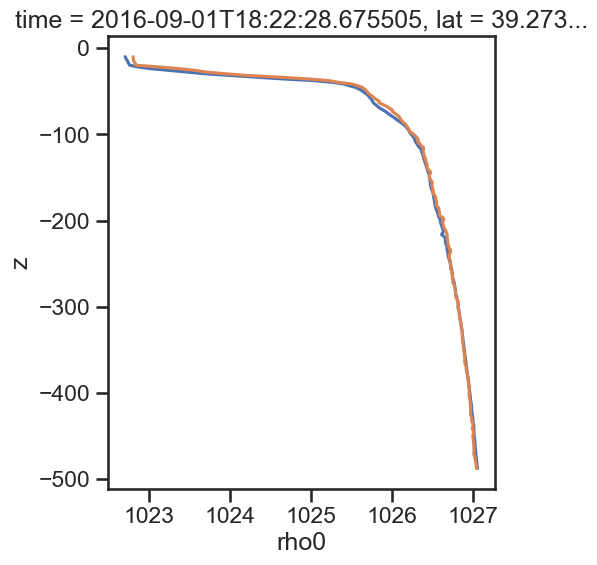

In [926]:
plt.figure(figsize=(5,6))
prof.rho_ref.plot(y='z')
prof.rho0.plot(y='z')

In [893]:
# make rho the coordinate
proff = prof.swap_dims({'z':'rho_ref'})

In [901]:
# depth of parcel with certain density
z2 = prof.rho0.isel(z=100).z

In [919]:
# depth that a parcel with certain density would have in the reference state
z1 = proff.interp(rho_ref=prof.rho0.isel(z=100)).z

<xarray.DataArray 'z' ()>
array(-214.37981164)
Coordinates:
    time      datetime64[ns] 2016-09-01T18:22:28.675505
    z         float64 -214.4
    pressure  float64 216.2
    lat       float64 39.27
    lon       float64 147.1
    rho_ref   float64 1.027e+03

In [933]:
# get z's for the whole profile
prof['zref'] = ('z', proff.interp(rho_ref=prof.rho0.values).z)

In [950]:
def integral(data,z1,z2):
    if z2>z1:
        data = data.where( (data.z >= z1) & (data.z < z2) ) # this is a problem because sometimes it will be the opposite order
        sign= -1
    else:
        data = data.where( (data.z >= z2) & (data.z < z1) )
        sign= 1
    data['z'] = data.z * (-1)*sign
    array = []
    return data.dropna('z').integrate('z')

In [951]:
def compute_ape(ds):
    liste=[]
    for i,z in enumerate(ds.z):
        liste.append( 9.81*integral(ds.rho_prime,z,ds.zref.isel(z=i)) )
    return xr.concat( liste, dim='z')

In [952]:
prof['ape'] = compute_ape(prof)

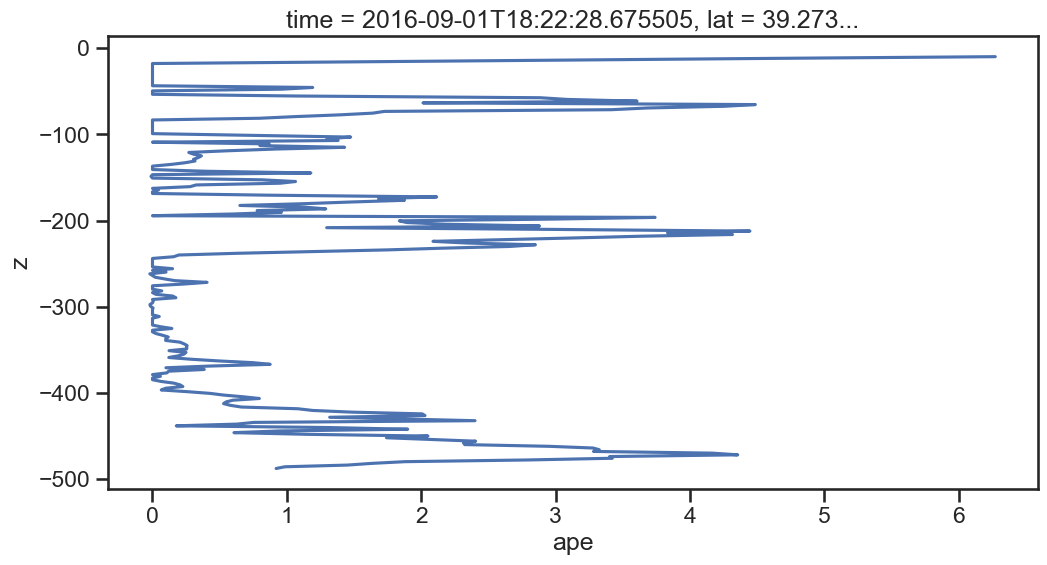

In [953]:
prof.ape.plot(y='z')

In [855]:
subset = raw.sel(time=slice('2016-10-01','2016-10-21'))

(-200, 0)

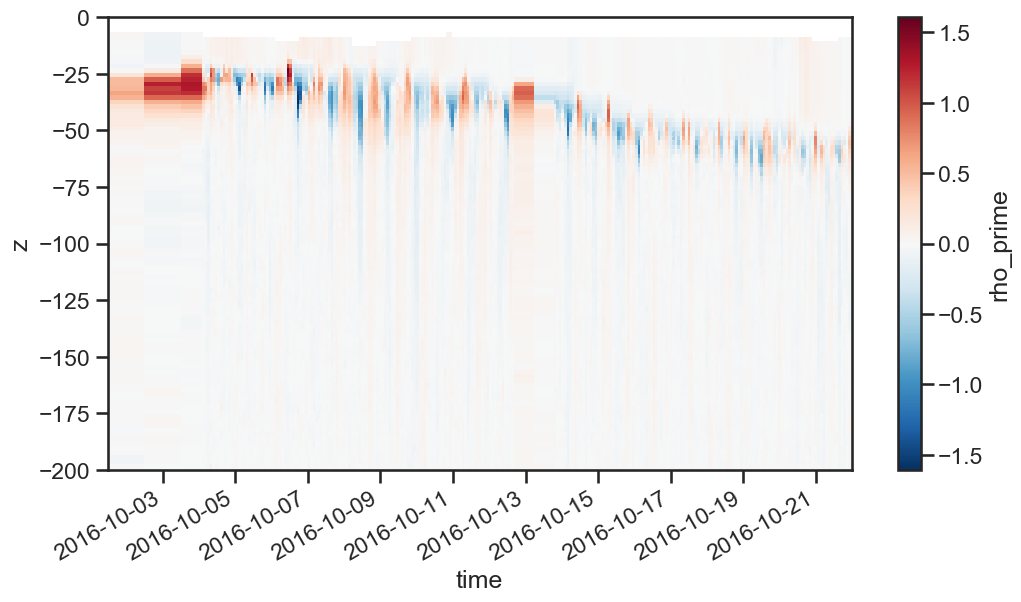

In [908]:
# subset.hke.plot()
subset.rho_prime.plot()
plt.ylim(-200,0)

In [809]:
g=9.81
zmin=-200
subset['ape_ml'] = ('time', integrate_columns(subset.ape, subset.mld,0)/1000 ) # divide by 1000 to get kJ
subset['ape_py'] = ('time', integrate_columns(subset.ape, zmin, subset.mld)/1000)

subset['hke_ml'] = ('time', integrate_columns(subset.hke, subset.mld,0)/1000)
subset['hke_py'] = ('time', integrate_columns(subset.hke, zmin, subset.mld)/1000)

subset['eps_ml'] = ('time', integrate_columns(subset.eps, subset.mld,0))
subset['eps_py'] = ('time', integrate_columns(subset.eps, zmin, subset.mld))

subset['hke_full'] = ('time', integrate_columns(subset.hke, zmin,0)/1000 )
subset['ape_full'] = ('time', integrate_columns(subset.ape, zmin,0)/1000 )

subset['ape_prime_ml'] = subset.ape_ml #- subset.ape_ml.isel(time=slice(0,10)).mean()
subset['ape_prime_py'] = subset.ape_py #- subset.ape_py.isel(time=slice(0,10)).mean()

subset['hke_prime_ml'] = subset.hke_ml #- subset.hke_ml.isel(time=slice(0,10)).mean()
subset['hke_prime_py'] = subset.hke_py #- subset.hke_py.isel(time=slice(0,10)).mean()

Text(0, 0.5, 'Energy [$kJ~m^{-2}$]')

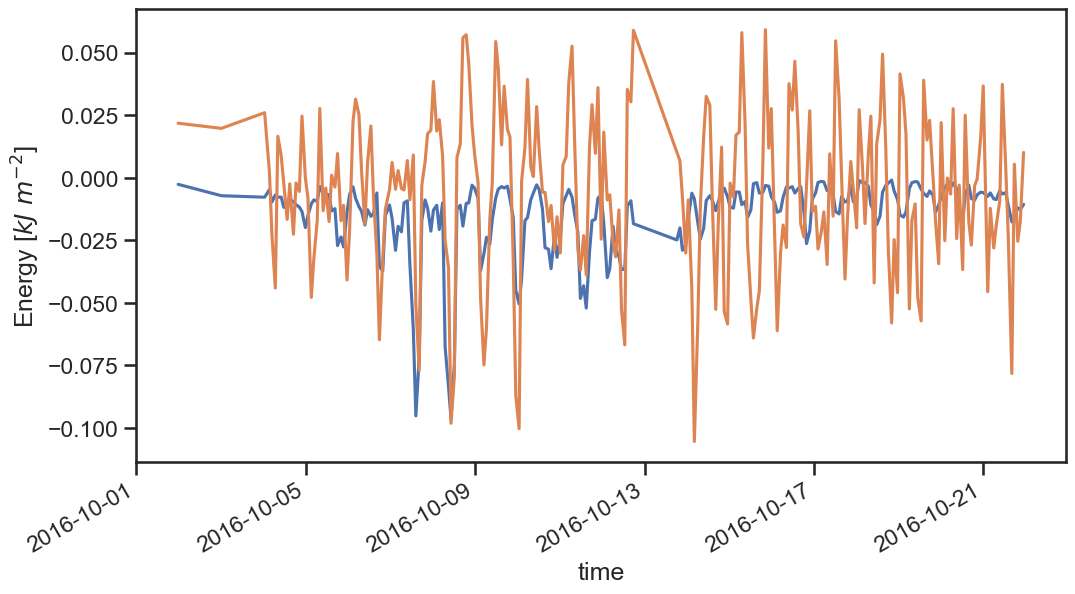

In [810]:
subset.hke_full.plot()
subset.ape_full.plot()

plt.ylabel('Energy [$kJ~m^{-2}$]')

In [811]:
taudotu_series = subset.taudotu.to_series()
taudotu_positive = taudotu_series[taudotu_series>0]*3
tau_series = subset.tau.to_series()

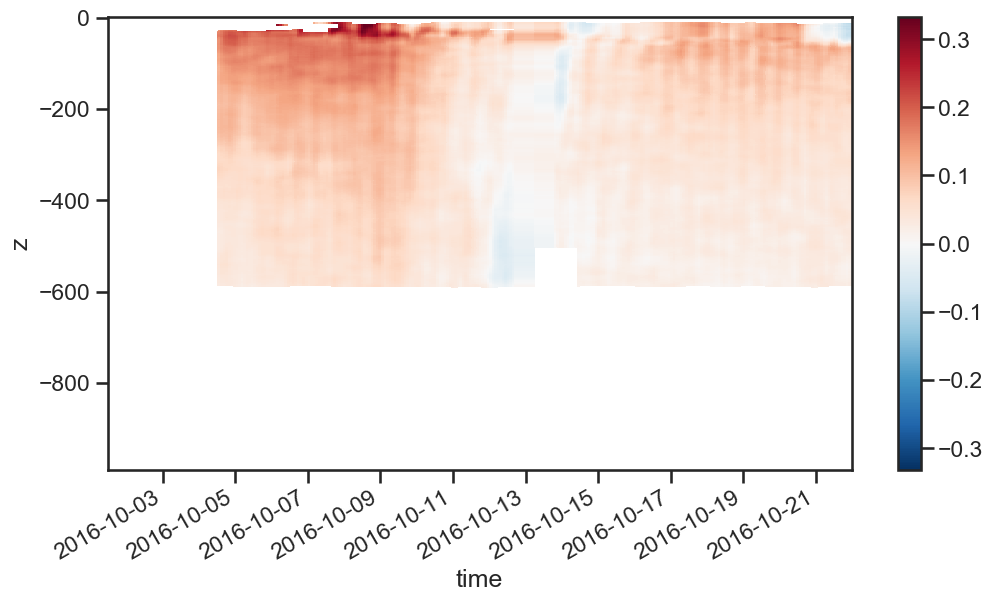

In [820]:
subset.v.rolling(time=10).mean().plot()

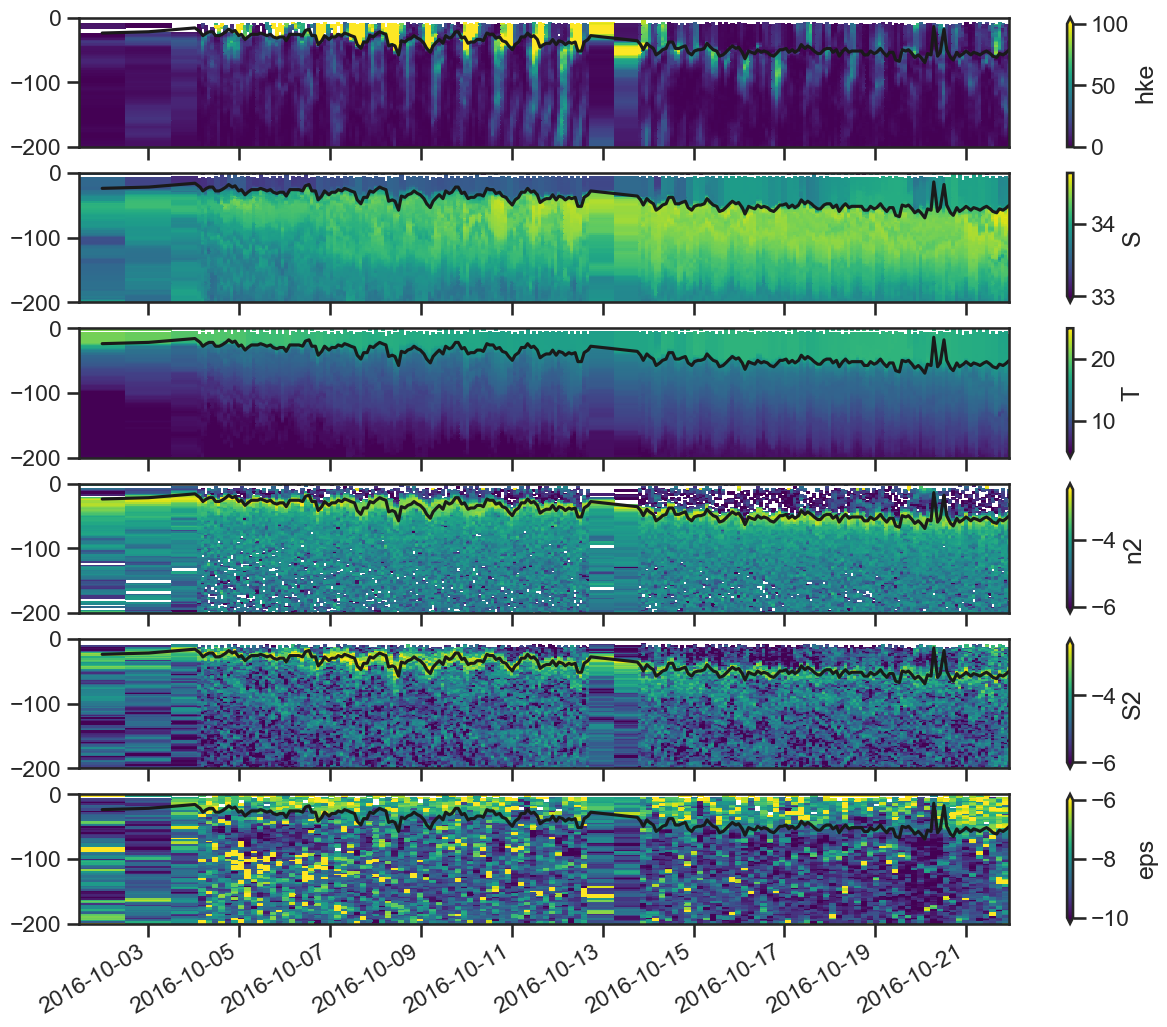

In [841]:
zmin=-200
f,ax = plt.subplots(6,1,figsize=(15,12), sharex=True)

subset.hke.plot(vmin=0,vmax=100, ax=ax[0])
subset.mld.plot(color='k', ax=ax[0], label='HKE')
ax[0].set_ylim(zmin,0)
ax[0].set_xlabel(None)
ax[0].set_ylabel(None)

subset.S.plot(vmin=33,vmax=34.7, ax=ax[1])
subset.mld.plot(color='k', ax= ax[1])
ax[1].set_ylim(zmin,0)
ax[1].set_xlabel(None)
ax[1].set_ylabel(None)

subset.T.plot(vmin=5,vmax=25, ax=ax[2])
subset.mld.plot(color='k', ax= ax[2])
ax[2].set_ylim(zmin,0)
ax[2].set_xlabel(None)
ax[2].set_ylabel(None)

subset.n2.pipe(np.log10).plot(vmin=-6,vmax=-2.5, ax=ax[3])
subset.mld.plot(color='k', ax= ax[3])
ax[3].set_ylim(zmin,0)
ax[3].set_xlabel(None)
ax[3].set_ylabel(None)

subset.S2.pipe(np.log10).plot(vmin=-6,vmax=-2.5, ax=ax[4])
subset.mld.plot(color='k', ax=ax[4])
ax[4].set_ylim(zmin,0)
ax[4].set_xlabel(None)
ax[4].set_ylabel(None)

subset.eps.dropna(dim='time',how='all').pipe(np.log10).plot(vmin=-10,vmax=-6, ax=ax[5])
subset.mld.plot(color='k', ax= ax[5])
ax[5].set_ylim(zmin,0)
ax[5].set_xlabel(None)
ax[5].set_ylabel(None);


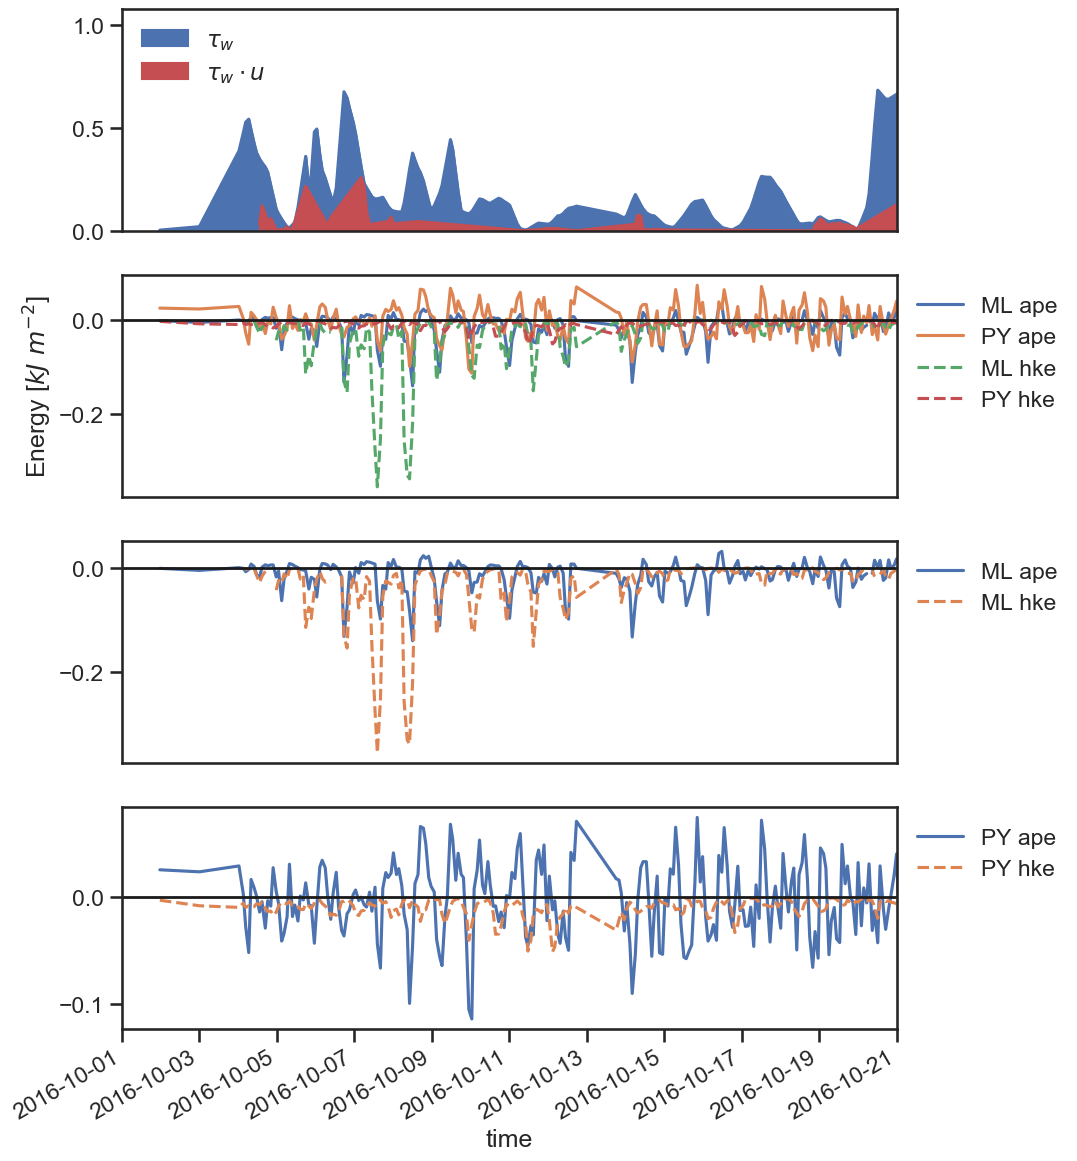

In [813]:
f = plt.figure(figsize=(10,15))

nplots=4
ax = f.add_subplot(nplots,1,1)
tau_series.plot.area(color='b',ax=ax, label=r'$\tau_w$')
taudotu_positive.plot.area(color='r',ax=ax,label=r'$\tau_w \cdot u$')

ax.set_xticks([])
ax.set_xlabel(None)
ax.legend()
ax.set_xlim('2016-10-01','2016-10-21')

ax = f.add_subplot(nplots,1,2)
subset.ape_prime_ml.plot(label=r'ML ape', ax=ax)
subset.ape_prime_py.plot(label=r'PY ape', ax=ax)
subset.hke_prime_ml.plot(label=r'ML hke',linestyle='dashed', ax=ax)
subset.hke_prime_py.plot(label=r'PY hke',linestyle='dashed', ax=ax)

ax.axhline(0, color='k',lw=2)
ax.legend()
ax.set_ylabel('Energy [$kJ~m^{-2}$]');
ax.legend(loc='upper left', bbox_to_anchor=(1, 1));
ax.set_xlim('2016-10-01','2016-10-21')
ax.set_xticks([])
ax.set_xlabel(None)

ax = f.add_subplot(nplots,1,3)
# taudotu_positive.plot(color='r',ax=ax,label=r'$\tau_w \cdot u$')
subset.ape_prime_ml.plot(label=r'ML ape', ax=ax)
subset.hke_prime_ml.plot(label=r'ML hke',linestyle='dashed', ax=ax)
ax.set_ylabel(None)
ax.legend(loc='upper left', bbox_to_anchor=(1, 1));
ax.axhline(0, color='k',lw=2);
ax.set_xlim('2016-10-01','2016-10-21');
ax.set_xticks([])
ax.set_xlabel(None)

ax = f.add_subplot(nplots,1,4)
# taudotu_positive.plot(color='r',ax=ax,label=r'$\tau_w \cdot u$')
subset.ape_prime_py.plot(label=r'PY ape', ax=ax)
subset.hke_prime_py.plot(label=r'PY hke',linestyle='dashed', ax=ax)
ax.set_ylabel(None)
ax.legend(loc='upper left', bbox_to_anchor=(1, 1));
ax.axhline(0, color='k',lw=2);
ax.set_xlim('2016-10-01','2016-10-21');

plt.savefig('../figures/test.pdf')

(-3.3186717486616413,
 -1.1943349234703973,
 -3.8044091108164197,
 -0.28328565355011204)

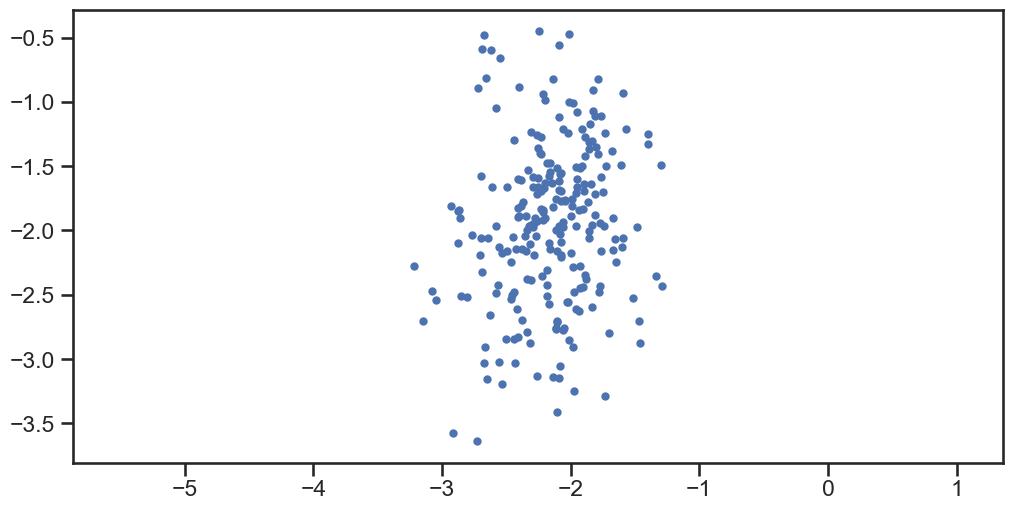

In [848]:
plt.scatter(subset.hke_prime_py.pipe(np.abs).pipe(np.log10),subset.hke_prime_ml.pipe(np.abs).pipe(np.log10),marker='.')
plt.axis('equal')

In [741]:
import xrscipy

In [742]:
from scipy.integrate import cumtrapz

In [743]:
subset['dt'] = ('time', subset.time.values.astype(int)*1e-9) 

In [744]:
datetime = pd.to_datetime( subset.time.values )

In [745]:
diff = datetime - datetime[0]

In [746]:
subset['diff'] = ('time',diff.total_seconds())

In [747]:
subset = subset.swap_dims({'time':'diff'})

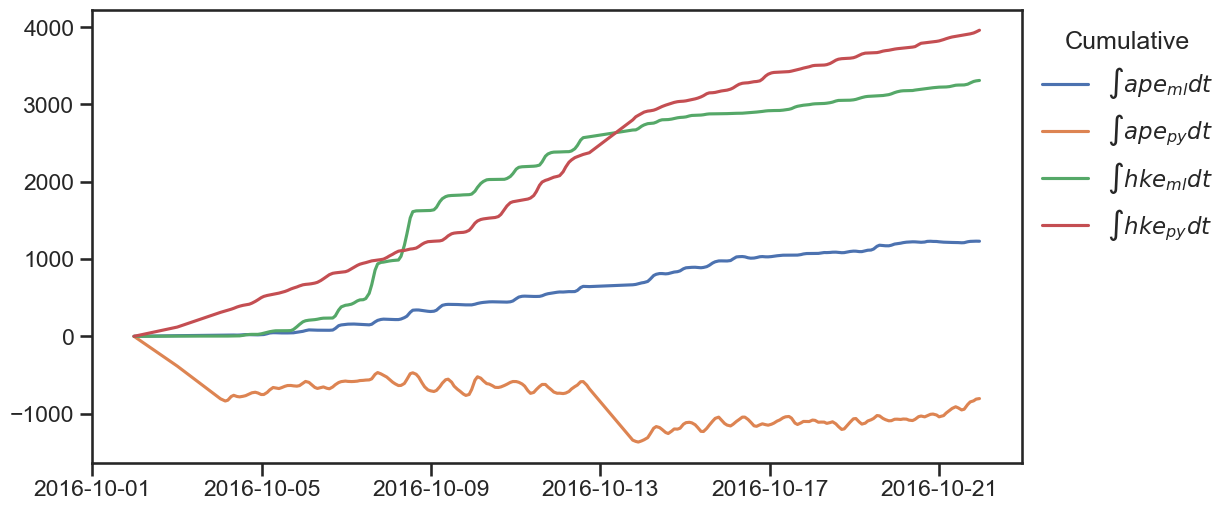

In [748]:
plt.plot(subset.time, xrscipy.integrate.cumtrapz( subset.ape_prime_ml.fillna(0), coord='diff', initial =0)/1000, label='$\int ape_{ml} dt$')
plt.plot(subset.time, xrscipy.integrate.cumtrapz( subset.ape_prime_py.fillna(0), coord='diff', initial =0)/1000, label='$\int ape_{py} dt$' )

plt.plot(subset.time, xrscipy.integrate.cumtrapz( subset.hke_prime_ml.fillna(0), coord='diff', initial =0)/1000 , label='$\int hke_{ml} dt$');
plt.plot(subset.time, xrscipy.integrate.cumtrapz( subset.hke_prime_py.fillna(0), coord='diff', initial =0)/1000 , label='$\int hke_{py} dt$');

plt.legend(loc='upper left', bbox_to_anchor=(1, 1), title='Cumulative');

In [749]:
subset = subset.swap_dims({'diff':'time'})

In [750]:
def divby100(df):
    return df/100

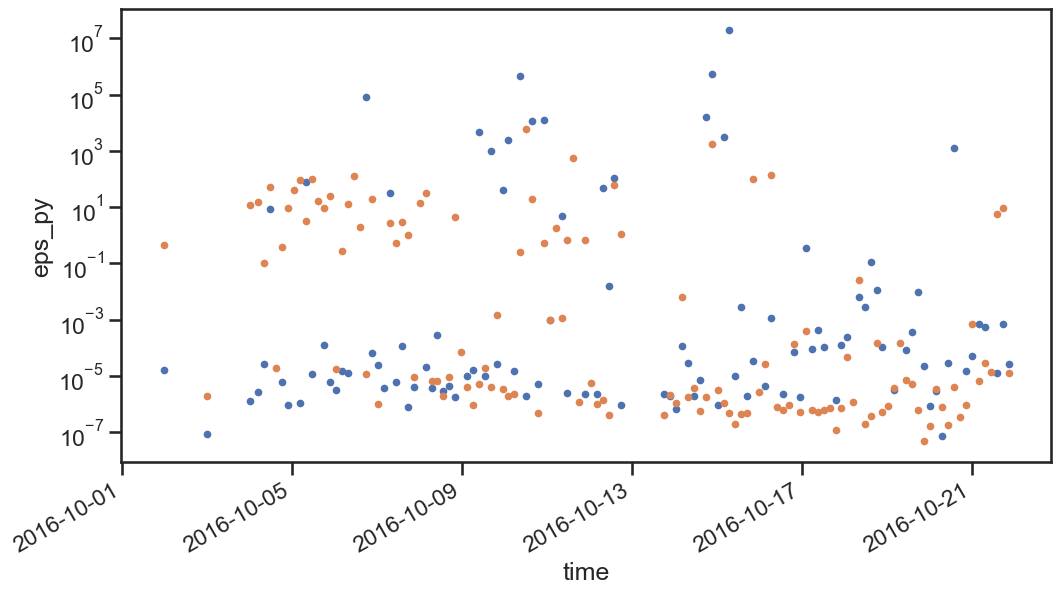

In [764]:
subset.eps_ml.plot(label=r'ML eps', marker='.',lw=0)
subset.eps_py.plot(label=r'PY eps', marker='.',lw=0)
plt.yscale('log')

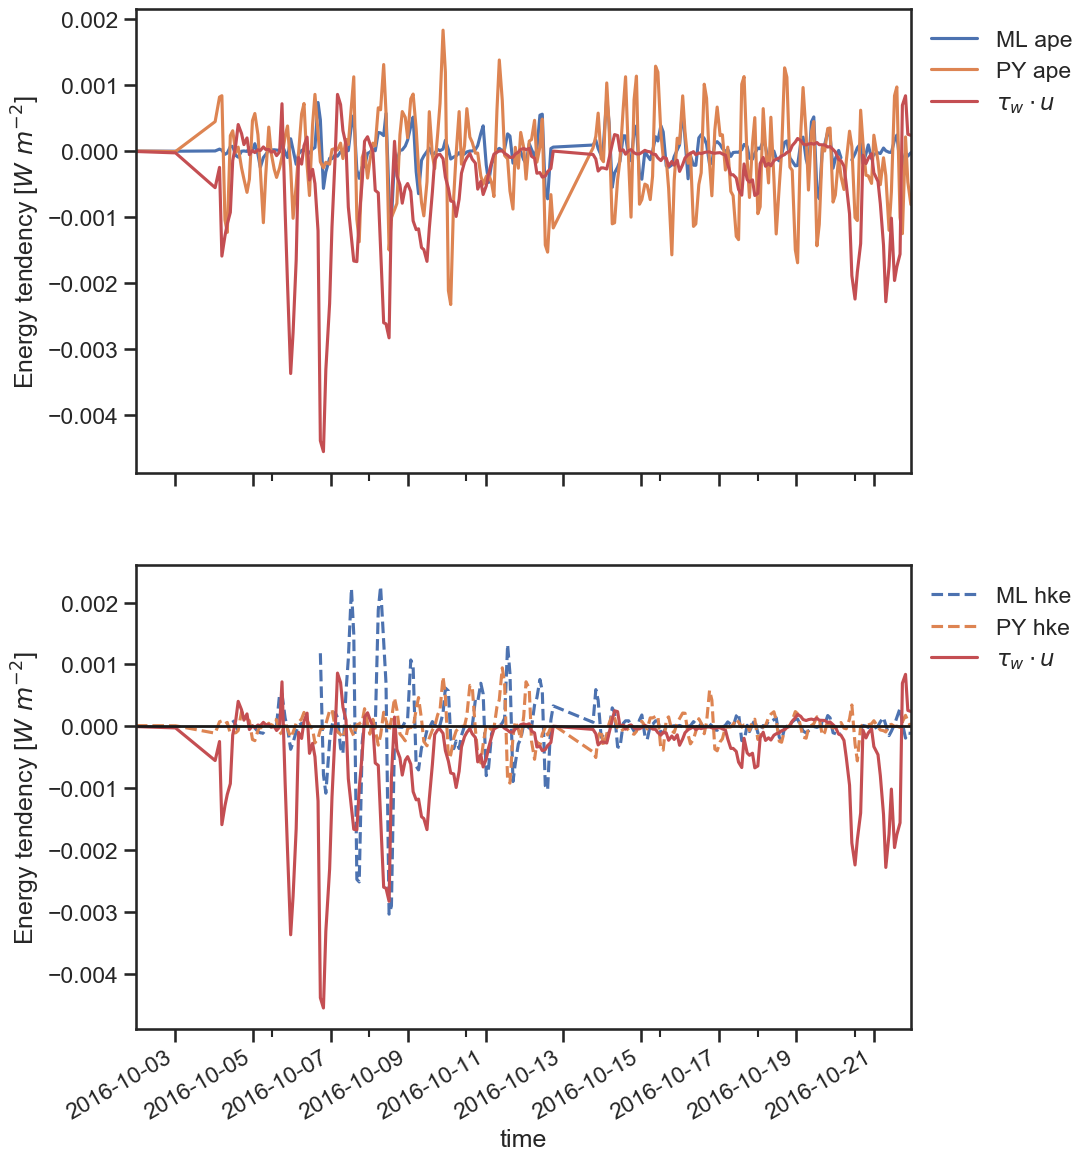

In [759]:
f = plt.figure(figsize=(10,15))
ax = f.add_subplot(2,1,1)
subset.ape_prime_ml.differentiate('time',datetime_unit='s').plot(label=r'ML ape', ax=ax)
subset.ape_prime_py.differentiate('time',datetime_unit='s').plot(label=r'PY ape', ax=ax)
taudotu_series.apply(divby100).plot(color='r',ax=ax,label=r'$\tau_w \cdot u$')
# subset.eps_ml.plot(label=r'ML eps',ax=ax)
# subset.eps_py.plot(label=r'PY eps',ax=ax)
ax.legend(loc='upper left', bbox_to_anchor=(1, 1));
ax.set_ylabel('Energy tendency [$W~m^{-2}$]');
# ax.set_ylim(-1,1)

ax = f.add_subplot(2,1,2,sharex=ax)
subset.hke_prime_ml.differentiate('time',datetime_unit='s').plot(label=r'ML hke',linestyle='dashed', ax=ax)
subset.hke_prime_py.differentiate('time',datetime_unit='s').plot(label=r'PY hke',linestyle='dashed', ax=ax)
taudotu_series.apply(divby100).plot(color='r',ax=ax,label=r'$\tau_w \cdot u$')
# subset.eps_ml.plot(label=r'ML eps',ax=ax)
# subset.eps_py.plot(label=r'PY eps',ax=ax)
ax.set_ylabel('Energy tendency [$W~m^{-2}$]');

ax.axhline(0, color='k',lw=2)
ax.legend(loc='upper left', bbox_to_anchor=(1, 1));

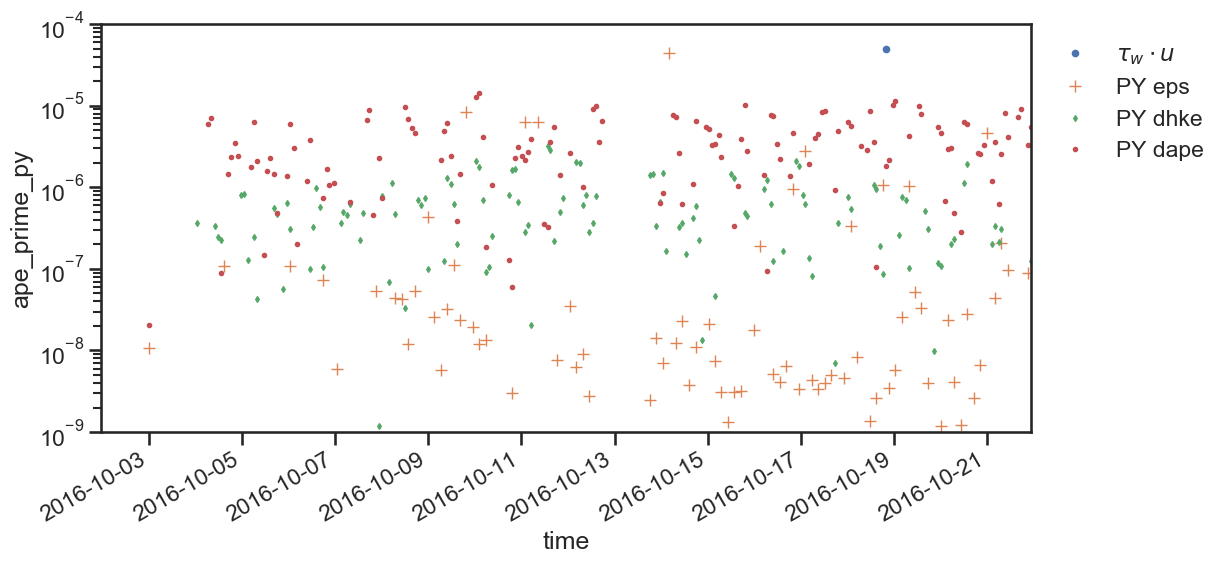

In [843]:
taudotu_series.plot(label=r'$\tau_w \cdot u$', marker='.',lw=0)

# subset.eps_ml.pipe(np.abs).plot(label=r'ML eps',marker='+',lw=0, ms=8)
subset.eps_py.pipe(np.abs).plot(label=r'PY eps',marker='+',lw=0, ms=8)

# subset.hke_prime_ml.differentiate('time',datetime_unit='s').plot(label=r'ML dhke', marker='d',lw=0, ms=3)
subset.hke_prime_py.differentiate('time',datetime_unit='s').plot(label=r'PY dhke', marker='d',lw=0, ms=3)

# subset.ape_prime_ml.differentiate('time',datetime_unit='s').plot(label=r'ML dape', marker='o',lw=0, ms=3)
subset.ape_prime_py.differentiate('time',datetime_unit='s').plot(label=r'PY dape', marker='o',lw=0, ms=3)

plt.ylim(1e-9,1e-4)
plt.yscale('log')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1));